## Group Project Title: Analysis of Blue Voters in Red States

Group Members: Joseph Chang, Grant Cai, Chen Guo, Baiming Wang

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, col, desc
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType,BooleanType,DateType
from pyspark.sql.functions import col, when, count

import pyspark as ps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as f

np.set_printoptions(precision = 3, linewidth = 100)

## Question that we are answering:

Republican states, or "red" states are defined as having a majority of the population voting for the Republican party. However, observations of these "red states" have found that the most prominent and most populous cities are actually mostly "blue", or voting for Democratic. We want to know if for every active voter, what is the voter turnout in the the big cities belonging to these "red" states and perhaps if it can be determined whether and why these populous cities will be blue. We also want to see which party these same voters belong to. We will analyze every presidential elections from 2000 to 2016.

Since there are many states to choose from, we will select states in the Southern region of the United States, most notably Texas, Alabama, and Georgia. For each of these states, we will choose some columns such as Voter_Gender, Voter_Age, Voters_Active, and then remove null values for each of the columns.

#### Count

In [64]:
states = ['VM2Uniform--AL--2021-02-04',
 'VM2Uniform--SC--2021-04-16',
 'VM2Uniform--TN--2021-03-29',
 'VM2Uniform--TX--2021-06-12']
gcs_path = 'gs://pstat135-voter-file/VM2Uniform/'
numrows = dict()
for one_state in states:
    print("%s: " % (one_state), end="")
    # read dataframe for one_state
    df = spark.read.parquet("/".join([gcs_path, one_state]))
    numrows[one_state] = df.select('Voters_Gender').count()

    print("%d" % (numrows[one_state]))

VM2Uniform--AL--2021-02-04: 

3458534
VM2Uniform--SC--2021-04-16: 

3318276
VM2Uniform--TN--2021-03-29: 

4076696
VM2Uniform--TX--2021-06-12: 

15983112


## The exploratory phase 

#### Calculate Number of Null value

In [86]:
alabama = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--AL--2021-02-04']))
alabama1 = alabama.select("Voters_Active", "Voters_Gender", "Voters_Age", 
            "MaritalStatus_Description", "EthnicGroups_EthnicGroup1Desc","Parties_Description")
alabama1 = alabama1.withColumnRenamed("EthnicGroups_EthnicGroup1Desc", "Ethnic_Group")
alabama1 = alabama1.withColumnRenamed("Parties_Description","Party")
alabama1 = alabama1.withColumnRenamed("MaritalStatus_Description","Marital_Status")


alabama1.select([count(when(col(c).isNull() , c)).alias(c) for c in alabama1.columns]).show()

+-------------+-------------+----------+--------------+------------+-----+
|Voters_Active|Voters_Gender|Voters_Age|Marital_Status|Ethnic_Group|Party|
+-------------+-------------+----------+--------------+------------+-----+
|            0|          236|      1862|       2002348|      150499|    0|
+-------------+-------------+----------+--------------+------------+-----+



#### Drop Missing Value for alabama1

In [87]:
alabama1_afterdrop = alabama1.select("Voters_Active", "Voters_Gender", "Voters_Age", 
            "Marital_Status", "Ethnic_Group","Party").\
na.drop(subset = ["Voters_Active", "Voters_Gender", "Voters_Age", 
            "Marital_Status", "Ethnic_Group","Party"]) 


In [88]:
alabama1_afterdrop.show(10)

+-------------+-------------+----------+---------------+--------------------+----------+
|Voters_Active|Voters_Gender|Voters_Age| Marital_Status|        Ethnic_Group|     Party|
+-------------+-------------+----------+---------------+--------------------+----------+
|            A|            M|        78|Non-Traditional|Likely African-Am...|Republican|
|            A|            F|        63|Non-Traditional|Likely African-Am...|Democratic|
|            A|            F|        66|        Married|            European|Republican|
|            A|            M|        64|        Married|            European|Republican|
|            A|            F|        56|        Married|Likely African-Am...|Democratic|
|            A|            M|        54|        Married|Likely African-Am...|Democratic|
|            A|            F|        44|        Married|Likely African-Am...|Democratic|
|            A|            M|        60|        Married|Likely African-Am...|Democratic|
|            A|      

#### Count the number of people per Voter Active for each Party

In [89]:
act = alabama1_afterdrop.groupby('Voters_Active','Party').count().sort(desc('count'))
act.show()

+-------------+------------+------+
|Voters_Active|       Party| count|
+-------------+------------+------+
|            A|  Republican|886772|
|            A|  Democratic|356142|
|            A|Non-Partisan| 65367|
|            I|  Republican| 48420|
|            I|  Democratic| 24042|
|            I|Non-Partisan|  7825|
+-------------+------------+------+



#### Plot the number of people per Voter Active for each Party

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


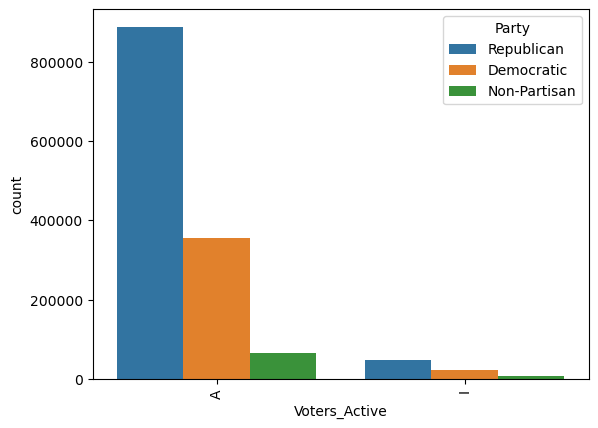

In [90]:
act1 = alabama1_afterdrop.toPandas()
sns.countplot(act1['Voters_Active'],hue = act1['Party'])
plt.xticks(rotation = 90, fontsize = 10)
plt.show()

#### Count the number of people per Ethnic Group for each Party

In [91]:
eth = alabama1_afterdrop.groupby('Ethnic_Group','Party').count().sort(desc('count'))
eth.show()

+--------------------+------------+------+
|        Ethnic_Group|       Party| count|
+--------------------+------------+------+
|            European|  Republican|906879|
|Likely African-Am...|  Democratic|233868|
|            European|  Democratic|115208|
|            European|Non-Partisan| 71567|
|Hispanic and Port...|  Democratic| 15667|
|Likely African-Am...|  Republican|  9333|
|East and South Asian|  Democratic|  8636|
|Hispanic and Port...|  Republican|  8592|
|               Other|  Democratic|  6805|
|               Other|  Republican|  5482|
|East and South Asian|  Republican|  4906|
|Hispanic and Port...|Non-Partisan|   824|
|East and South Asian|Non-Partisan|   311|
|Likely African-Am...|Non-Partisan|   257|
|               Other|Non-Partisan|   233|
+--------------------+------------+------+



#### Plot the number of peole per Ethnic Group for each Party

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


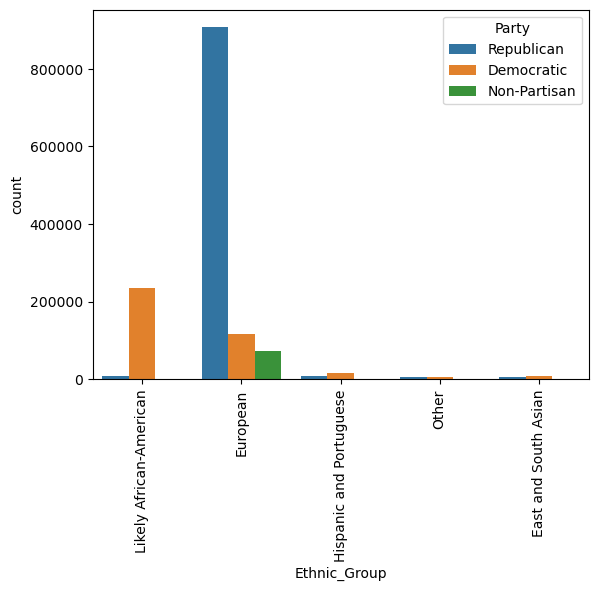

In [92]:
eth1 = alabama1_afterdrop.toPandas()
sns.countplot(eth1['Ethnic_Group'],hue = eth1['Party'])
plt.xticks(rotation = 90, fontsize = 10)
plt.show()

In [93]:
alabama2 = alabama.select("Religions_Description", "Languages_Description", 
                  "AbsenteeTypes_Description", "CommercialData_Education", 
                  "CommercialData_EstimatedHHIncome", "CommercialData_Occupation","Parties_Description")
alabama2 = alabama2.withColumnRenamed("Religions_Description","Religion")
alabama2 = alabama2.withColumnRenamed("Languages_Description","Language")
alabama2 = alabama2.withColumnRenamed("AbsenteeTypes_Description","Residence")
alabama2 = alabama2.withColumnRenamed("CommercialData_Education","Education")
alabama2 = alabama2.withColumnRenamed("CommercialData_EstimatedHHIncome","HH_Income")
alabama2 = alabama2.withColumnRenamed("CommercialData_Occupation","Occupation")
alabama2 = alabama2.withColumnRenamed("Parties_Description","Party")
alabama2.select([count(when(col(c).isNull() , c)).alias(c) for c in alabama2.columns]).show()

+--------+--------+---------+---------+---------+----------+-----+
|Religion|Language|Residence|Education|HH_Income|Occupation|Party|
+--------+--------+---------+---------+---------+----------+-----+
| 1931920| 1718292|  3458534|  1374157|   109205|   1561568|    0|
+--------+--------+---------+---------+---------+----------+-----+



In [67]:
alabama2.show(10)

+----------+--------+---------+--------------------+------------+------------------+------------+
|  Religion|Language|Residence|           Education|   HH_Income|        Occupation|       Party|
+----------+--------+---------+--------------------+------------+------------------+------------+
|      null|    null|     null|Some College - Li...|$75000-99999|           Unknown|  Democratic|
|      null|    null|     null|Some College - Li...|$75000-99999|           Unknown|  Democratic|
|Protestant| English|     null|Grad Degree - Ext...|$35000-49999|Medical-Pharmacist|  Republican|
|      null|    null|     null|                null|$75000-99999|              null|Non-Partisan|
|Protestant| English|     null|HS Diploma - Extr...|$15000-24999|           Unknown|  Republican|
|Protestant| English|     null|Bach Degree - Ext...|$15000-24999|           Unknown|  Democratic|
|      null|    null|     null| HS Diploma - Likely|$75000-99999|           Unknown|  Republican|
|      null|    null

In [30]:
na = df.select('Voters_Gender','Voters_Age',\
                   'CommercialData_Education',\
               'ElectionReturns_G16_Cnty_Vote_Trump_R','ElectionReturns_G16_Cnty_Vote_Clinton_D')
na_map = na.toPandas()

tf_na = na_map.isnull()

tf_na.head(10)

,Voters_Gender,Voters_Age,CommercialData_Education,ElectionReturns_G16_Cnty_Vote_Trump_R,ElectionReturns_G16_Cnty_Vote_Clinton_D
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,False,False,False
4,False,False,True,False,False
5,False,False,False,False,False
6,False,False,False,False,False
7,False,False,True,False,False
8,False,False,True,False,False
9,False,False,True,False,False


Here, we wanted to see how many null values were in each column. We see that only CommercialData_Education has missing values.

#### Drop Missing Value 

In [6]:
data = df.select('Voters_Gender', 'Voters_Age',\
                'CommercialData_Education',\
                 'ElectionReturns_G16_Cnty_Vote_Trump_R',\
                 'ElectionReturns_G16_Cnty_Vote_Clinton_D')\
.na.drop(subset = ['Voters_Gender','Voters_Age',\
                   'CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R',\
                   'ElectionReturns_G16_Cnty_Vote_Clinton_D'])


#### Display the Data

In [7]:
data.show(10)
print('Total Records in dataset',data.count())

+-------------+----------+------------------------+-------------------------------------+---------------------------------------+
|Voters_Gender|Voters_Age|CommercialData_Education|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|
+-------------+----------+------------------------+-------------------------------------+---------------------------------------+
|            F|        47|     HS Diploma - Likely|                                18172|                                   5936|
|            F|        53|    HS Diploma - Extr...|                                18172|                                   5936|
|            F|        60|     HS Diploma - Likely|                                18172|                                   5936|
|            M|        30|     HS Diploma - Likely|                                18172|                                   5936|
|            F|        24|    Some College - Li...|                                18172| 

Total Records in dataset 2083910


#### Count the number of people per education level

We will sort the education level column so we can group together and count the number of people per group.

In [7]:
edu = data.groupby('CommercialData_Education').count().sort(desc('count'))
edu.show()

+------------------------+------+
|CommercialData_Education| count|
+------------------------+------+
|    Some College - Li...|379198|
|    HS Diploma - Extr...|371870|
|    Bach Degree - Ext...|369955|
|     HS Diploma - Likely|286480|
|    Bach Degree - Likely|163518|
|    Grad Degree - Ext...|151805|
|    Less than HS Dipl...|134428|
|    Grad Degree - Likely|111082|
|    Some College -Ext...|109899|
|    Vocational Techni...|  4449|
|    Less than HS Dipl...|  1226|
+------------------------+------+



/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


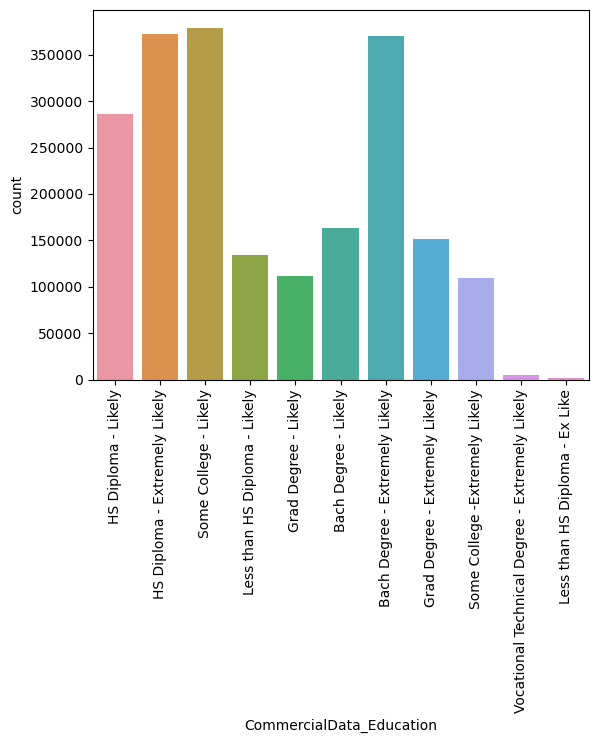

In [8]:
edu1 =data.toPandas()
sns.countplot(edu1['CommercialData_Education'])
plt.xticks(rotation = 90, fontsize = 10)
plt.show()

Here, we can see that the *Some College - Likely* has the highest proprotion of `CommercialData_Education` in our state dataset.

#### Create a Bar graph of the number of votes for each party per county

In [9]:
df1 = df.select("County","ElectionReturns_G16_Cnty_Vote_Trump_R",'ElectionReturns_G16_Cnty_Vote_Clinton_D').distinct()
df1.show()

+--------+-------------------------------------+---------------------------------------+
|  County|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|
+--------+-------------------------------------+---------------------------------------+
| BALDWIN|                                72883|                                  18458|
| BARBOUR|                                 5454|                                   4871|
|  BUTLER|                                 4901|                                   3726|
| BULLOCK|                                 1140|                                   3530|
| CALHOUN|                                32865|                                  13242|
|CHAMBERS|                                 7843|                                   5784|
|CHEROKEE|                                 8953|                                   1547|
|  CLARKE|                                 7140|                                   5749|
| CHOCTAW|           

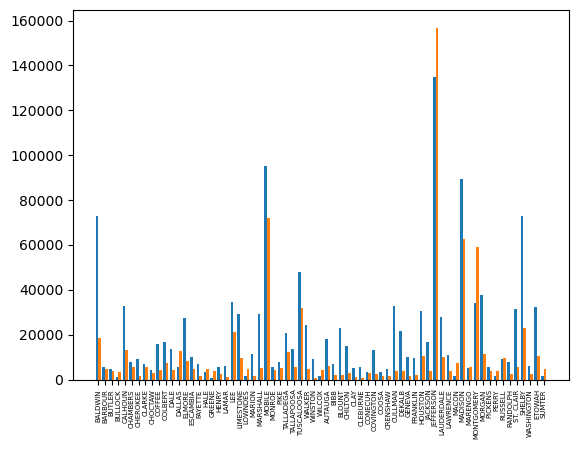

In [10]:
Voter = df1.toPandas()
X = Voter['County']
Yrep = Voter['ElectionReturns_G16_Cnty_Vote_Trump_R']
Ydem = Voter['ElectionReturns_G16_Cnty_Vote_Clinton_D']

Xaxis = np.arange(len(X))

plt.bar(Xaxis-0.2, Yrep, 0.4, label = 'Republican votes')
plt.bar(Xaxis+0.2, Ydem, 0.4, label = 'Democratic votes')
plt.xticks(Xaxis, X, rotation = 90, fontsize = 5);

Here, we are looking at the columns: ElectionReturns_G16_Cnty_Vote_Trump_R and ElectionReturns_G16_Cnty_Vote_Clinton_D. These columns prints the number of votes for Republican and Democratic respectively per county.

#### Furthermore, we want to consider the correlation between the voter's background and voter turnout to find out the true behavior behind the voting patterns for the 'red' states.


## Team Assignment2 starts here

In [34]:
from pyspark.sql.functions import col, when, count
na_values = df.select('Voters_Gender','Voters_Age',\
        'CommercialData_Education','ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16_Cnty_Vote_Clinton_D')
na_values.select([count(when(col(c).isNull() , c)).alias(c) for c in na_values.columns]
   ).show()

+-------------+----------+------------------------+-------------------------------------+---------------------------------------+
|Voters_Gender|Voters_Age|CommercialData_Education|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|
+-------------+----------+------------------------+-------------------------------------+---------------------------------------+
|        10512|      7448|                 6085819|                                    0|                                      0|
+-------------+----------+------------------------+-------------------------------------+---------------------------------------+



In [4]:
states = ['VM2Uniform--AL--2021-02-04',
 'VM2Uniform--SC--2021-04-16',
 'VM2Uniform--TN--2021-03-29',
 'VM2Uniform--TX--2021-06-12']
gcs_path = 'gs://pstat135-voter-file/VM2Uniform/'
numrows = dict()
for one_state in states:
    print("%s: " % (one_state), end="")
    # read dataframe for one_state
    df = spark.read.parquet("/".join([gcs_path, one_state]))
    numrows[one_state] = df.select('Voters_Gender').count()

    print("%d" % (numrows[one_state]))

VM2Uniform--AL--2021-02-04: 

3458534
VM2Uniform--SC--2021-04-16: 

3318276
VM2Uniform--TN--2021-03-29: 

4076696
VM2Uniform--TX--2021-06-12: 

15983112


+--------------+-------------+-------------+---------------------------------+-------------------------+
|    LALVOTERID|Voters_Gender|Voters_Active|VoterParties_Change_Changed_Party|MaritalStatus_Description|
+--------------+-------------+-------------+---------------------------------+-------------------------+
|  LALTX4113095|            F|            A|             Between 2 and 4 Y...|                  Married|
|  LALTX4113090|            M|            A|               Within Last 1 Year|                  Married|
|LALTX470661193|            M|            A|             Between 2 and 4 Y...|                  Married|
|  LALTX4115262|            F|            A|             Between 2 and 4 Y...|                  Married|
|  LALTX4118706|            M|            A|               Within Last 1 Year|                  Married|
|  LALTX4123857|            M|            A|               Within Last 1 Year|                  Married|
|  LALTX4122568|            M|            A|           

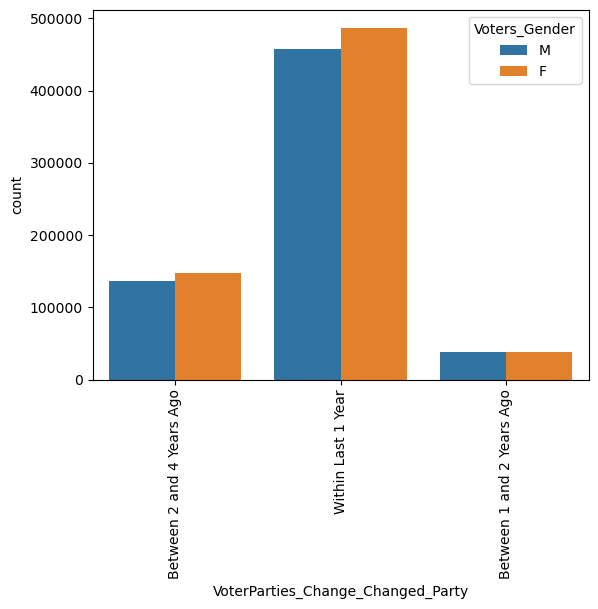

In [10]:
new_df = df.select("LALVOTERID", "Voters_Gender", "Voters_Active", "VoterParties_Change_Changed_Party", "MaritalStatus_Description")

new_df.filter(df.Voters_Active == "A").filter(df.MaritalStatus_Description == "Married").na.drop().show()

new_df = new_df.toPandas()


sns.countplot(x='VoterParties_Change_Changed_Party', hue = "Voters_Gender", data = new_df)

plt.xticks(rotation = 90, fontsize = 10)

plt.show()


Here, we can see that most of the voter parties changed their partied within last 1 year from this plot.

#### Create the county swing column

#### 2008

In [14]:
alabama = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--AL--2021-02-04']))
bama2008 = alabama.select('County', 'ElectionReturns_G08_Cnty_Vote_McCain_R', 'ElectionReturns_G08_Cnty_Vote_Obama_D',
        'ElectionReturns_G08CountyTurnoutRepublicans', 'ElectionReturns_G08CountyTurnoutDemocrats').distinct()
bama2008 = bama2008.withColumnRenamed("ElectionReturns_G08_Cnty_Vote_McCain_R","McCain_Votes")
bama2008 = bama2008.withColumnRenamed("ElectionReturns_G08_Cnty_Vote_Obama_D","Obama_Votes")
bama2008 = bama2008.withColumnRenamed("ElectionReturns_G08CountyTurnoutDemocrats","Democratic_Turnout")
bama2008 = bama2008.withColumnRenamed("ElectionReturns_G08CountyTurnoutRepublicans","Republican_Turnout")

In [15]:
bama2008 = bama2008.withColumn("McCain_Votes", bama2008.McCain_Votes.cast(IntegerType()))
bama2008 = bama2008.withColumn("Obama_Votes", bama2008.Obama_Votes.cast(IntegerType()))
bama2008 = bama2008.withColumn('VoteRepub', bama2008['McCain_Votes'] > bama2008['Obama_Votes'])

bama2008.printSchema()
bama2008 = bama2008.withColumn("County_Swing08", f.when(f.col("VoteRepub") == True, "Republican").otherwise("Democrat")) 
#The column County_Swing has some problems.
bama2008.show(10)

root
 |-- County: string (nullable = true)
 |-- McCain_Votes: integer (nullable = true)
 |-- Obama_Votes: integer (nullable = true)
 |-- Republican_Turnout: string (nullable = true)
 |-- Democratic_Turnout: string (nullable = true)
 |-- VoteRepub: boolean (nullable = true)



+---------+------------+-----------+------------------+------------------+---------+--------------+
|   County|McCain_Votes|Obama_Votes|Republican_Turnout|Democratic_Turnout|VoteRepub|County_Swing08|
+---------+------------+-----------+------------------+------------------+---------+--------------+
|  JACKSON|       14083|       6374|               85%|               65%|     true|    Republican|
|JEFFERSON|      149921|     166121|               82%|               68%|    false|      Democrat|
|   COFFEE|       14919|       5079|               77%|               69%|     true|    Republican|
|  CHOCTAW|        4223|       3636|               77%|               71%|     true|    Republican|
|   WALKER|       20722|       7420|               91%|               61%|     true|    Republican|
|  CONECUH|        3470|       3429|               74%|               64%|     true|    Republican|
|  CULLMAN|       28896|       5864|               75%|               67%|     true|    Republican|


#### 2012

In [26]:
bama2012 = alabama.select('County','ElectionReturns_G12_Cnty_Vote_Romney_R', 'ElectionReturns_G12_Cnty_Vote_Obama_D',
        'ElectionReturns_G12CountyTurnoutRepublicans', 'ElectionReturns_G12CountyTurnoutDemocrats').distinct()
bama2012 = bama2012.withColumnRenamed("ElectionReturns_G12_Cnty_Vote_Romney_R","Romney_Votes")
bama2012 = bama2012.withColumnRenamed("ElectionReturns_G12_Cnty_Vote_Obama_D","Obama_Votes")
bama2012 = bama2012.withColumnRenamed("ElectionReturns_G12CountyTurnoutDemocrats","Democratic_Turnout")
bama2012 = bama2012.withColumnRenamed("ElectionReturns_G12CountyTurnoutRepublicans","Republican_Turnout")

bama2012 = bama2012.withColumn("Romney_Votes", bama2012.Romney_Votes.cast(IntegerType()))
bama2012 = bama2012.withColumn("Obama_Votes", bama2012.Obama_Votes.cast(IntegerType()))
bama2012 = bama2012.withColumn('VoteRepub', bama2012['Romney_Votes'] > bama2012['Obama_Votes'])

bama2012.printSchema()
bama2012 = bama2012.withColumn("County_Swing12", f.when(f.col("VoteRepub") == True, "Republican").otherwise("Democrat")) 
#The column County_Swing has some problems.
bama2012.show(10)

root
 |-- County: string (nullable = true)
 |-- Romney_Votes: integer (nullable = true)
 |-- Obama_Votes: integer (nullable = true)
 |-- Republican_Turnout: string (nullable = true)
 |-- Democratic_Turnout: string (nullable = true)
 |-- VoteRepub: boolean (nullable = true)



+--------+------------+-----------+------------------+------------------+---------+--------------+
|  County|Romney_Votes|Obama_Votes|Republican_Turnout|Democratic_Turnout|VoteRepub|County_Swing12|
+--------+------------+-----------+------------------+------------------+---------+--------------+
|  SHELBY|       71436|      20051|               75%|               62%|     true|    Republican|
| BARBOUR|        5550|       5912|               73%|               64%|    false|      Democrat|
|  ETOWAH|       29130|      12803|               83%|               57%|     true|    Republican|
|  DEKALB|       18331|       5239|               85%|               53%|     true|    Republican|
| MADISON|       90884|      62015|               73%|               60%|     true|    Republican|
| WINSTON|        8312|       1286|               63%|               53%|     true|    Republican|
|FRANKLIN|        7567|       3171|               74%|               50%|     true|    Republican|
|  WILCOX|

#### 2016

In [27]:
bama2016 = alabama.select('County','ElectionReturns_G16_Cnty_Vote_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Clinton_D',
        'ElectionReturns_G16CountyTurnoutRepublicans', 'ElectionReturns_G16CountyTurnoutDemocrats').distinct()
bama2016 = bama2016.withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R","Trump_Votes")
bama2016 = bama2016.withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D","Clinton_Votes")
bama2016 = bama2016.withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats","Democratic_Turnout")
bama2016 = bama2016.withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans","Republican_Turnout")

bama2016 = bama2016.withColumn("Trump_Votes", bama2016.Trump_Votes.cast(IntegerType()))
bama2016 = bama2016.withColumn("Clinton_Votes", bama2016.Clinton_Votes.cast(IntegerType()))
bama2016 = bama2016.withColumn('VoteRepub', bama2016['Trump_Votes'] > bama2016['Clinton_Votes'])

bama2016.printSchema()
bama2016 = bama2016.withColumn("County_Swing16", f.when(f.col("VoteRepub") == True, "Republican").otherwise("Democrat")) 
#The column County_Swing has some problems.
bama2016.show(10)

root
 |-- County: string (nullable = true)
 |-- Trump_Votes: integer (nullable = true)
 |-- Clinton_Votes: integer (nullable = true)
 |-- Republican_Turnout: string (nullable = true)
 |-- Democratic_Turnout: string (nullable = true)
 |-- VoteRepub: boolean (nullable = true)



+----------+-----------+-------------+------------------+------------------+---------+--------------+
|    County|Trump_Votes|Clinton_Votes|Republican_Turnout|Democratic_Turnout|VoteRepub|County_Swing16|
+----------+-----------+-------------+------------------+------------------+---------+--------------+
|    ETOWAH|      32353|        10442|               78%|               51%|     true|    Republican|
|    SUMTER|       1581|         4746|               78%|               60%|    false|      Democrat|
|TUSCALOOSA|      47723|        31762|               71%|               57%|     true|    Republican|
|   CALHOUN|      32865|        13242|               71%|               55%|     true|    Republican|
|    ELMORE|      27634|         8443|               74%|               62%|     true|    Republican|
|    MARION|      11274|         1432|               82%|               54%|     true|    Republican|
|  CRENSHAW|       4513|         1664|               68%|               57%|     t

#### Visualize the demographic of voter's party

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Parties_Description', ylabel='count'>

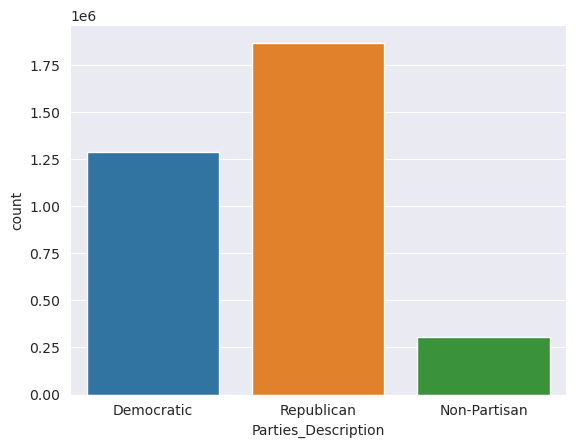

In [28]:
alabama_party = alabama.select("Parties_Description").toPandas()
sns.set_style('darkgrid')
sns.countplot(alabama_party['Parties_Description'])

Here, we can see that most of the voter voted for Republican party in alabama from this plot.

#### Count the percent of people voted for republican in alabama

In [29]:
num_voter_repu = new_ala[new_ala.VoteRepub == True].count()

In [30]:
total_num_voter = new_ala.count()

In [31]:
voter_repu_percent = num_voter_repu/total_num_voter
voter_repu_percent

0.7847574991242424

Here, we can see that the percent of voter in alabama state voted for republican party was 0.785

### Logistic Regression

In [32]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="County_Swing ~  Voters_Active + Voters_Gender+CommercialData_Education" )

In [33]:
fittedRF = supervised.fit(new_ala)  # fit the transformer
preparedDF = fittedRF.transform(new_ala)  # transform
preparedDF.show(5, False)

+-------------+-------------+----------+---------------------------------+------------------------------+-------------------------------------+---------------------------------------+---------+------------+--------------------------+-----+
|Voters_Active|Voters_Gender|Voters_Age|VoterParties_Change_Changed_Party|CommercialData_Education      |ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|VoteRepub|County_Swing|features                  |label|
+-------------+-------------+----------+---------------------------------+------------------------------+-------------------------------------+---------------------------------------+---------+------------+--------------------------+-----+
|A            |F            |24        |null                             |Some College - Likely         |13267                                |2387                                   |true     |Republican  |(12,[0,1,2],[1.0,1.0,1.0])|0.0  |
|A            |F            |23        |

In [34]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
test.show(2)

+-------------+-------------+----------+---------------------------------+------------------------+-------------------------------------+---------------------------------------+---------+------------+--------------------+-----+
|Voters_Active|Voters_Gender|Voters_Age|VoterParties_Change_Changed_Party|CommercialData_Education|ElectionReturns_G16_Cnty_Vote_Trump_R|ElectionReturns_G16_Cnty_Vote_Clinton_D|VoteRepub|County_Swing|            features|label|
+-------------+-------------+----------+---------------------------------+------------------------+-------------------------------------+---------------------------------------+---------+------------+--------------------+-----+
|            A|            F|       100|                             null|    Bach Degree - Ext...|                                 6712|                                   1362|     true|  Republican|(12,[0,1,4],[1.0,...|  0.0|
|            A|            F|       100|                             null|    Bach Degre

In [35]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label",featuresCol="features")

In [36]:
fittedLR = lr.fit(train)

In [37]:
fittedLR.transform(test).select("label", "prediction",'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.77106148192876...|
|  0.0|       0.0|[0.77106148192876...|
|  0.0|       0.0|[0.77106148192876...|
|  0.0|       0.0|[0.77106148192876...|
|  0.0|       0.0|[0.72598186326751...|
|  1.0|       0.0|[0.74193657687129...|
|  0.0|       0.0|[0.79348469287095...|
|  0.0|       0.0|[0.79348469287095...|
|  0.0|       0.0|[0.79348469287095...|
|  0.0|       0.0|[0.79134146550143...|
+-----+----------+--------------------+
only showing top 10 rows



In [38]:
summary = fittedLR.summary 

In [39]:
print(summary.accuracy, summary.weightedPrecision, summary.weightedRecall)

0.7849671786234498 0.616173471516059 0.7849671786234498


In [40]:
summary.areaUnderROC

0.5450044717800271

##### For the Team Assignment 2, we calculated the percent of the voter who voted for republican party in alabama. We also built a Logistic regression model for predicting the voter turnout behavior change. We now have the AUC value equals to 0.545, which means it is similar to a random select. There is another problem we found in our logistic model that the prediciton value is always zero. We will further investigate them.